# Import packages and load to orignal log of UWV

In [59]:
from sklearn.utils import resample
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
from treeinterpreter import treeinterpreter as ti
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
import seaborn

In [2]:


def date_parser(s):
    """
    Parse a date string using the log file's format. For example: '2015/10/16 11:25:59.000'
    """
    without_ms = s.split('.')[0]
    return datetime.datetime.strptime(without_ms, '%Y/%m/%d %H:%M:%S')

log = pd.read_csv('data/log.csv', parse_dates=['startTime', 'completeTime'], date_parser=date_parser)

# Events without an event type are pretty useless so we might as well drop them
log.dropna(axis=0, subset=['event'], inplace=True)
log.head()

,case,event,startTime,completeTime,agecategory,office_w,NumberWerkMapMessages,office_u,NumberComplaints,gender,...,questiontopicid,questionsubthemeid,event_office_w,tip_en,service_detail,ipid,event_office_u,questiontheme_en,complainttopic_en,service_detail_en
1,1445,Visit page mijn_cv,2015-08-07 10:52:27,2015-08-07 10:52:27,30-39,291,0,296,0,M,...,NaN,NaN,291.0,NaN,NaN,1048748.0,296.0,NaN,NaN,NaN
2,1445,Visit page home,2015-08-07 10:53:08,2015-08-07 10:53:08,30-39,291,0,296,0,M,...,NaN,NaN,291.0,NaN,NaN,1048748.0,296.0,NaN,NaN,NaN
3,1445,Visit page mijn_cv,2015-08-07 10:53:14,2015-08-07 10:53:14,30-39,291,0,296,0,M,...,NaN,NaN,291.0,NaN,NaN,1048748.0,296.0,NaN,NaN,NaN
4,1445,Visit page home,2015-08-07 10:53:38,2015-08-15 19:05:12,30-39,291,0,296,0,M,...,NaN,NaN,291.0,NaN,NaN,1048748.0,296.0,NaN,NaN,NaN
5,1445,Visit page foutopgetreden.html,2015-08-15 19:05:15,2015-08-15 19:05:15,30-39,291,0,296,0,M,...,NaN,NaN,291.0,NaN,NaN,1048748.0,296.0,NaN,NaN,NaN


In [3]:
log['sessionid'].nunique()

106221

In [4]:
sad_log_1Q=pd.read_csv('data/sad_log_1Q.csv', encoding= "ISO-8859-1")
happy_log=pd.read_csv('data/happy_log.csv', encoding= "ISO-8859-1")

C:\Users\s157084\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
sad_log_1Q['asked_question']=1
happy_log['asked_question']=0
log=pd.concat([happy_log, sad_log_1Q], axis=0)
log['sessionid'].nunique()

97729

# Create session summary
## Aggregate log by sessions

In [6]:
# Make sure the list of activities per session will be ordered by time
log.sort_values(['sessionid', 'startTime'], ascending=[True, True], inplace=True)
log['startTime']=log['completeTime']

# Define aggregations when looking at each session
aggregations = {'event': lambda x: list(x), 
                'case': 'first',
                'startTime': 'first', 
                'completeTime': 'last', 
                'gender': 'first',
                'agecategory': 'first',
                'asked_question': 'first',
               }
sessions = log.groupby('sessionid', as_index=False).agg(aggregations)

In [7]:
def sessions_customers(sessions, x):
    SS=sessions[sessions['case']==x['case']].sort_values('startTime').reset_index(drop=True)
    total_sessions=len(SS)
    sessions_so_far=SS[SS['sessionid']==x['sessionid']].index[0]
    return total_sessions, sessions_so_far

from tqdm import tqdm
tqdm.pandas(tqdm())
sessions2=sessions.copy()

sessions['total_sessions'], sessions['sessions_so_far'] = zip(*sessions.progress_apply(lambda x: sessions_customers(sessions2, x), axis=1))

0it [00:00, ?it/s]
 11%|█         | 10426/97729 [00:16<02:10, 670.83it/s]


 19%|█▉        | 18469/97729 [00:32<02:03, 641.19it/s]


 29%|██▊       | 27976/97729 [00:49<01:42, 680.99it/s]


 39%|███▉      | 38164/97729 [01:05<01:29, 667.47it/s]


 50%|████▉     | 48400/97729 [01:22<01:24, 586.40it/s]


 60%|█████▉    | 58182/97729 [01:38<00:59, 664.46it/s]


 70%|███████   | 68698/97729 [01:54<00:49, 585.16it/s]


 81%|████████  | 78909/97729 [02:10<00:27, 686.10it/s]


 91%|█████████ | 88859/97729 [02:26<00:12, 683.84it/s]


100%|██████████| 97729/97729 [02:41<00:00, 604.18it/s]

## Remove reoccurences of questions

In [8]:
def eliminate_leakage(event_list, including=True):
    """
    Cut sessions at the point where a question is asked, (including the question itself or not).
    If the trace does not include a question, return it unchanged.
    """
    try:
        question_index = event_list.index('Question')
        if including:
            question_index = question_index + 1
        else:
            question_index = question_index
        return event_list[:question_index]
    except ValueError:
        return event_list
    
#sessions['event'] = sessions['event'].apply(eliminate_leakage)

# Feature Engineering

## Age category, Max loops, hour, gender 

In [9]:
from collections import Counter

# If there is a question within a session, return a 1, else a 0
def asked_question(event_list):
    return int(event_list[-1] == 'Question')

# Ordinal mapping of age categories
def age(age_cat):
    mapping = {'30-39': 35, '50-65': 57, '40-49': 45, '18-29': 23}
    return mapping[age_cat]

# This function returns:
# 1) The most visisted page within the session
# 2) The times that page is visited
def max_loops(event_list):
    num_events=len(event_list)
    event_counter = Counter(event_list)
    most_visited_page = max(event_counter, key=event_counter.get)
    times_visited = event_counter[most_visited_page]
    if times_visited == 1:
        most_visited_page = None
        
    inds=[index for index, value in enumerate(event_list) if value==most_visited_page]
    if len(inds)==0:
        avg_steps=0
    else:
        steps=np.diff(inds)
        avg_steps=np.mean(steps)+1
    return most_visited_page, times_visited, avg_steps, num_events

# The hour of the timestamp can be seen as a feature
def hour(timestamp):
    return timestamp.hour

# Gender of a customer
def gender(gender):
    """
    This could be done directly on the DF but lets keep the same style for everything
    """
    return int(gender == 'M')

    
# Create target variable - Did this session end up with a question?
#sessions['asked_question'] = sessions['event'].apply(asked_question)
#sessions['event'] = sessions['event'].apply(eliminate_leakage,including=False)

# Gender from character to int
sessions['gender'] = sessions['gender'].apply(gender)

# Age from category to int and rename column
sessions['agecategory'] = sessions['agecategory'].apply(age)
sessions.rename(columns={'agecategory': 'age'}, inplace=True)

# Hour of day when the session took place.
sessions['startTime']=sessions['startTime'].apply(pd.to_datetime)
sessions['completeTime']=sessions['completeTime'].apply(pd.to_datetime)
sessions['hour'] = sessions['startTime'].apply(hour)

timediff=sessions['completeTime']-sessions['startTime']
sessions['timediff'] = timediff.apply(lambda x: x.seconds)

# Max number of page reoccurence within the sessions and the page mostly visited. 
# If each page was visited once then mostly visited will be None. The start syntax is interesting,
# it allows the apply function to create multiple outputs. This could be useful for the TODO step
# mentioned below.
sessions['most_visited_page'], sessions['max_loops'], sessions['avg_steps'], sessions['num_events'] = zip(*sessions['event'].apply(max_loops))

############################################# TODO ########################################################
### We could use the 'most_visited' column to create smart dummy variables. For example something like: ### 
### Is the home page the mostly visited, or the same for other interesting pages.                       ###
############################################# TODO ########################################################

## Presence of trigger events by Markov Chain model 

In [10]:
trigger_events= ['Visit page mijn_werkmap','Visit page home','Visit page taken',
                 'Visit page vacatures_bij_mijn_cv','Visit page mijn_berichten',
                 'Visit page werkmap','Visit page mijn_documenten',
                 'Visit page mijn_sollicitaties','Visit page mijn_cv',
                 'Visit page mijn_tips','Visit page inschrijven',
                 'Visit page foutopgetreden.html']

for event in trigger_events:
    sessions[event]=sessions['event'].apply(lambda x: int(event in x))

# Machine Learning to predict questions

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler

y = sessions['asked_question']
# Include more columns in the future!
X = sessions.drop(['asked_question', 'sessionid', 'startTime', 'completeTime', 'most_visited_page', 'event', 'case', 'total_sessions'], axis=1)
features = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [68]:
param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8], 'class_weight':[{1: w} for w in [1, 2, 3, 4, 5, 6, 10]]}
#param_grid = {'C':[1,10]}

clf=RandomForestClassifier(random_state = 42)
grid = GridSearchCV(clf, param_grid, cv=3,scoring='roc_auc',n_jobs=3, verbose=3)
model=grid.fit(X_train, y_train)
    
best_parameters, score, _ = max(model.grid_scores_, key=lambda x: x[1])
print('Normalized AUC:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    5.2s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:   14.1s
[Parallel(n_jobs=3)]: Done 147 out of 147 | elapsed:   16.7s finished
C:\Users\s157084\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Normalized AUC: 0.671037060272
class_weight: {1: 2}
max_depth: 7


In [69]:
model = RandomForestClassifier(max_depth=best_parameters[param_name], class_weight={1: 2}, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={1: 2}, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

# 1. xgboost Model (Santiago)



##  1.1 Model Creation

In [ ]:
# import xgboost as xgb

# tuning_params = {'max_depth': [3,4,5,6,7,8]}

# grid = GridSearchCV(xgb.XGBClassifier(objective= 'binary:logistic'), tuning_params, cv=3,scoring='roc_auc',n_jobs=3,verbose=3)
# model = grid.fit(X_train, y_train)

# best_parameters, score, _ = max(model.grid_scores_, key=lambda x: x[1])
# print('Normalized AUC:', score)
# for param_name in sorted(best_parameters.keys()):
#     print("%s: %r" % (param_name, best_parameters[param_name]))

    
# model = xgb.XGBClassifier(max_depth=best_parameters[param_name])
# model.fit(X_train, y_train)



## 1.2 Optimal Threshold

In [70]:
def optimal_threshold(fpr, tpr, thresholds):
    """
    This funtion select the threshold where the sum of sensitivity and specificity are maximum.

    This creiteria is based on:
    Bayesian regression methodology for estimating a receiver operating characteristic curve with two radiologic applications: 
    prostate biopsy and spiral CT of ureteral stones.
    
    #Parameters:
    - From the ROC 
    a) fpr: false positive rate
    b) tpr: true positive rate
    c) thresholds: thresholds
    
    """
    sensitivity = tpr
    specificity = 1 - fpr
    opt_threshold = np.argmax(sensitivity + specificity)
    opt_fpr = fpr[opt_threshold]
    opt_trp = tpr[opt_threshold]
    
    
    return thresholds[opt_threshold], opt_fpr, opt_trp


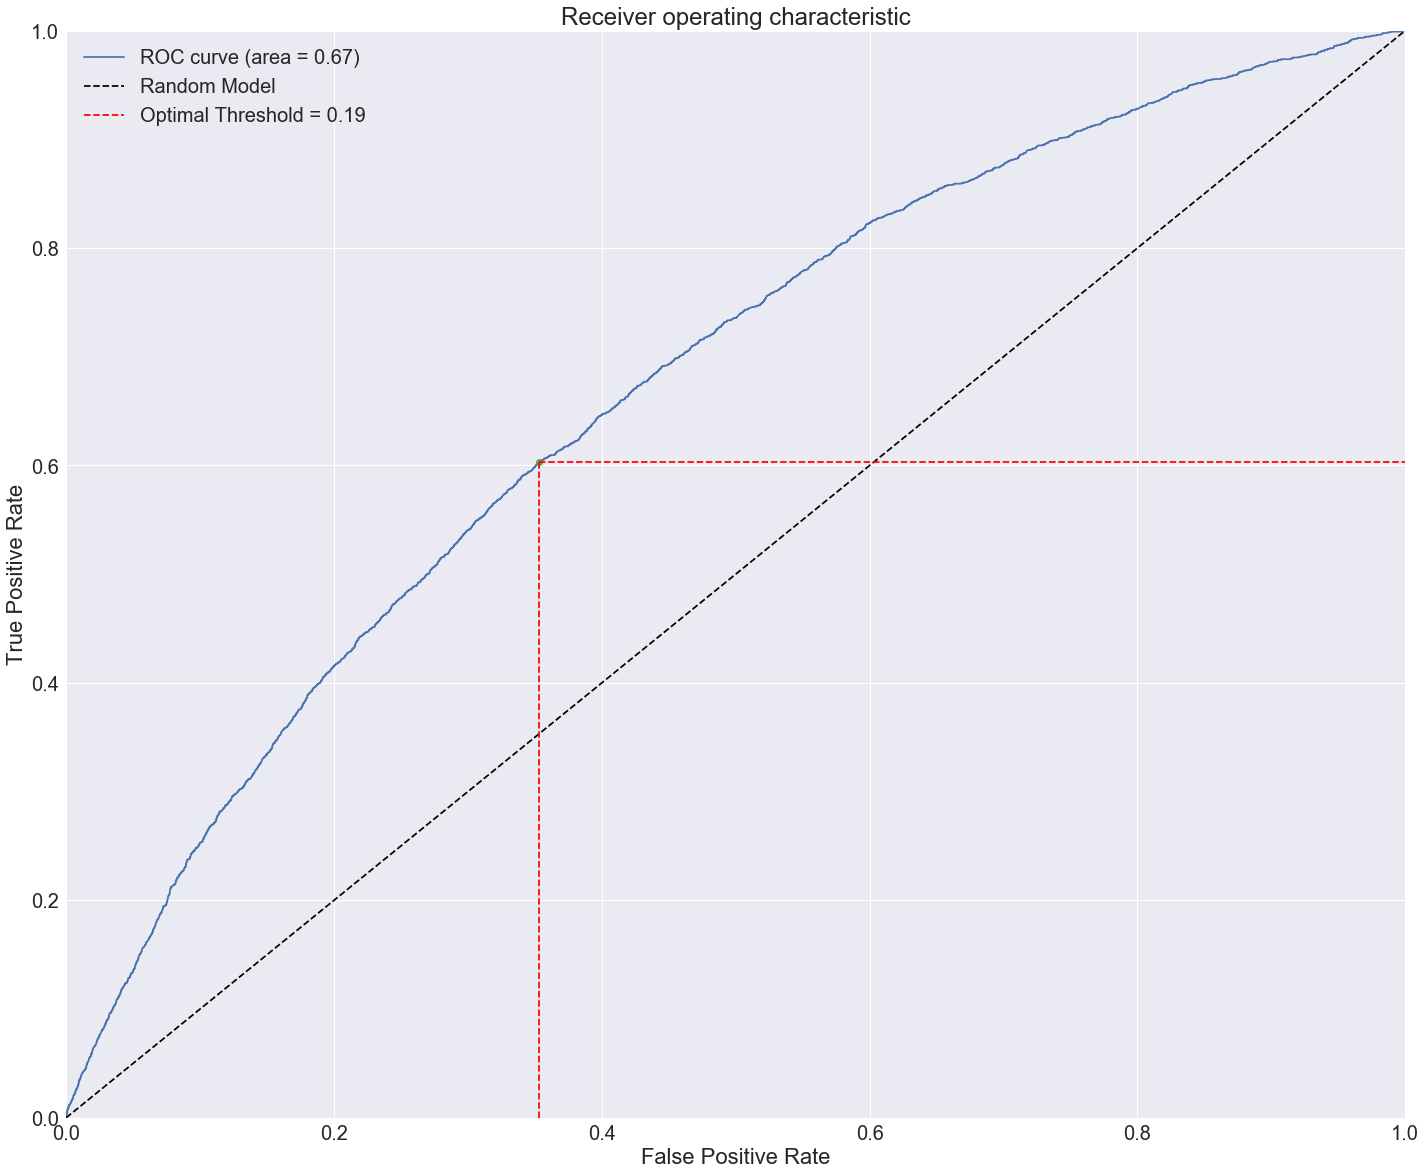

In [71]:

#Taken from: http://abhay.harpale.net/blog/machine-learning/threshold-tuning-using-roc/

#Predit the prob
predictions_prob = model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, predictions_prob)
roc_auc = auc(fpr, tpr)
opt_threshold, opt_fpr, opt_trp = optimal_threshold(fpr, tpr, thresholds)


sns.set(font_scale=2)
plt.figure(figsize=(24, 20))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--',label = 'Random Model')
#plt.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r', label = 'Threshold')
plt.plot(opt_fpr, opt_trp, 'o',linewidth=3)
plt.axvline(x = opt_fpr, ymax = opt_trp, linestyle='dashed', color='r'  )
plt.axhline(y = opt_trp, xmin =opt_fpr , linestyle='dashed', color='r' ,label = 'Optimal Threshold = %0.2f' % (opt_threshold) )


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='upper left')

#plt.savefig('roc_and_threshold.png')
plt.show()
plt.close()



In [72]:
opt_threshold, opt_fpr, opt_trp = optimal_threshold(fpr, tpr, thresholds)
predictions= predictions_prob.copy()
predictions[predictions<opt_threshold] = 0
predictions[predictions>=opt_threshold] = 1
print(confusion_matrix(y_test, predictions))
print(round(accuracy_score(y_test, predictions),2))

[[18821 10277]
 [ 1251  1902]]
0.64


In [73]:
#Impact of the variables
#This model was taken from:
    #https://github.com/andosa/treeinterpreter
    #http://blog.datadive.net/random-forest-interpretation-with-scikit-learn/
    #Predition = bias + feature_contribution

    
def calculate_contributions(model, X, y, under_sampling = True):  
    #Use the SMOTE algorithm to oversample the data set
        #from: http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.over_sampling.SMOTE.html
    if under_sampling == True:
        sm = RandomUnderSampler(random_state=0)
    else:
        sm = SMOTE(random_state=42)
        
    X_res, y_res = sm.fit_sample(X, y)
    prediction_ti, bias, contributions = ti.predict(model, X_res)
    total_contribution = np.mean(contributions, axis=0)[:,0] #The mean value of the contribution of each feature
    print(X.shape)
    print(X_res.shape)
    #prediction_ti, bias, contributions = ti.predict(model, X[y == 1])
    #total_contribution_Q = np.mean(contributions, axis=0)[:,0] #The mean value of the contribution of each feature
    return total_contribution

total_contribution = calculate_contributions(model, X, y)

(97729, 20)
(19068, 20)


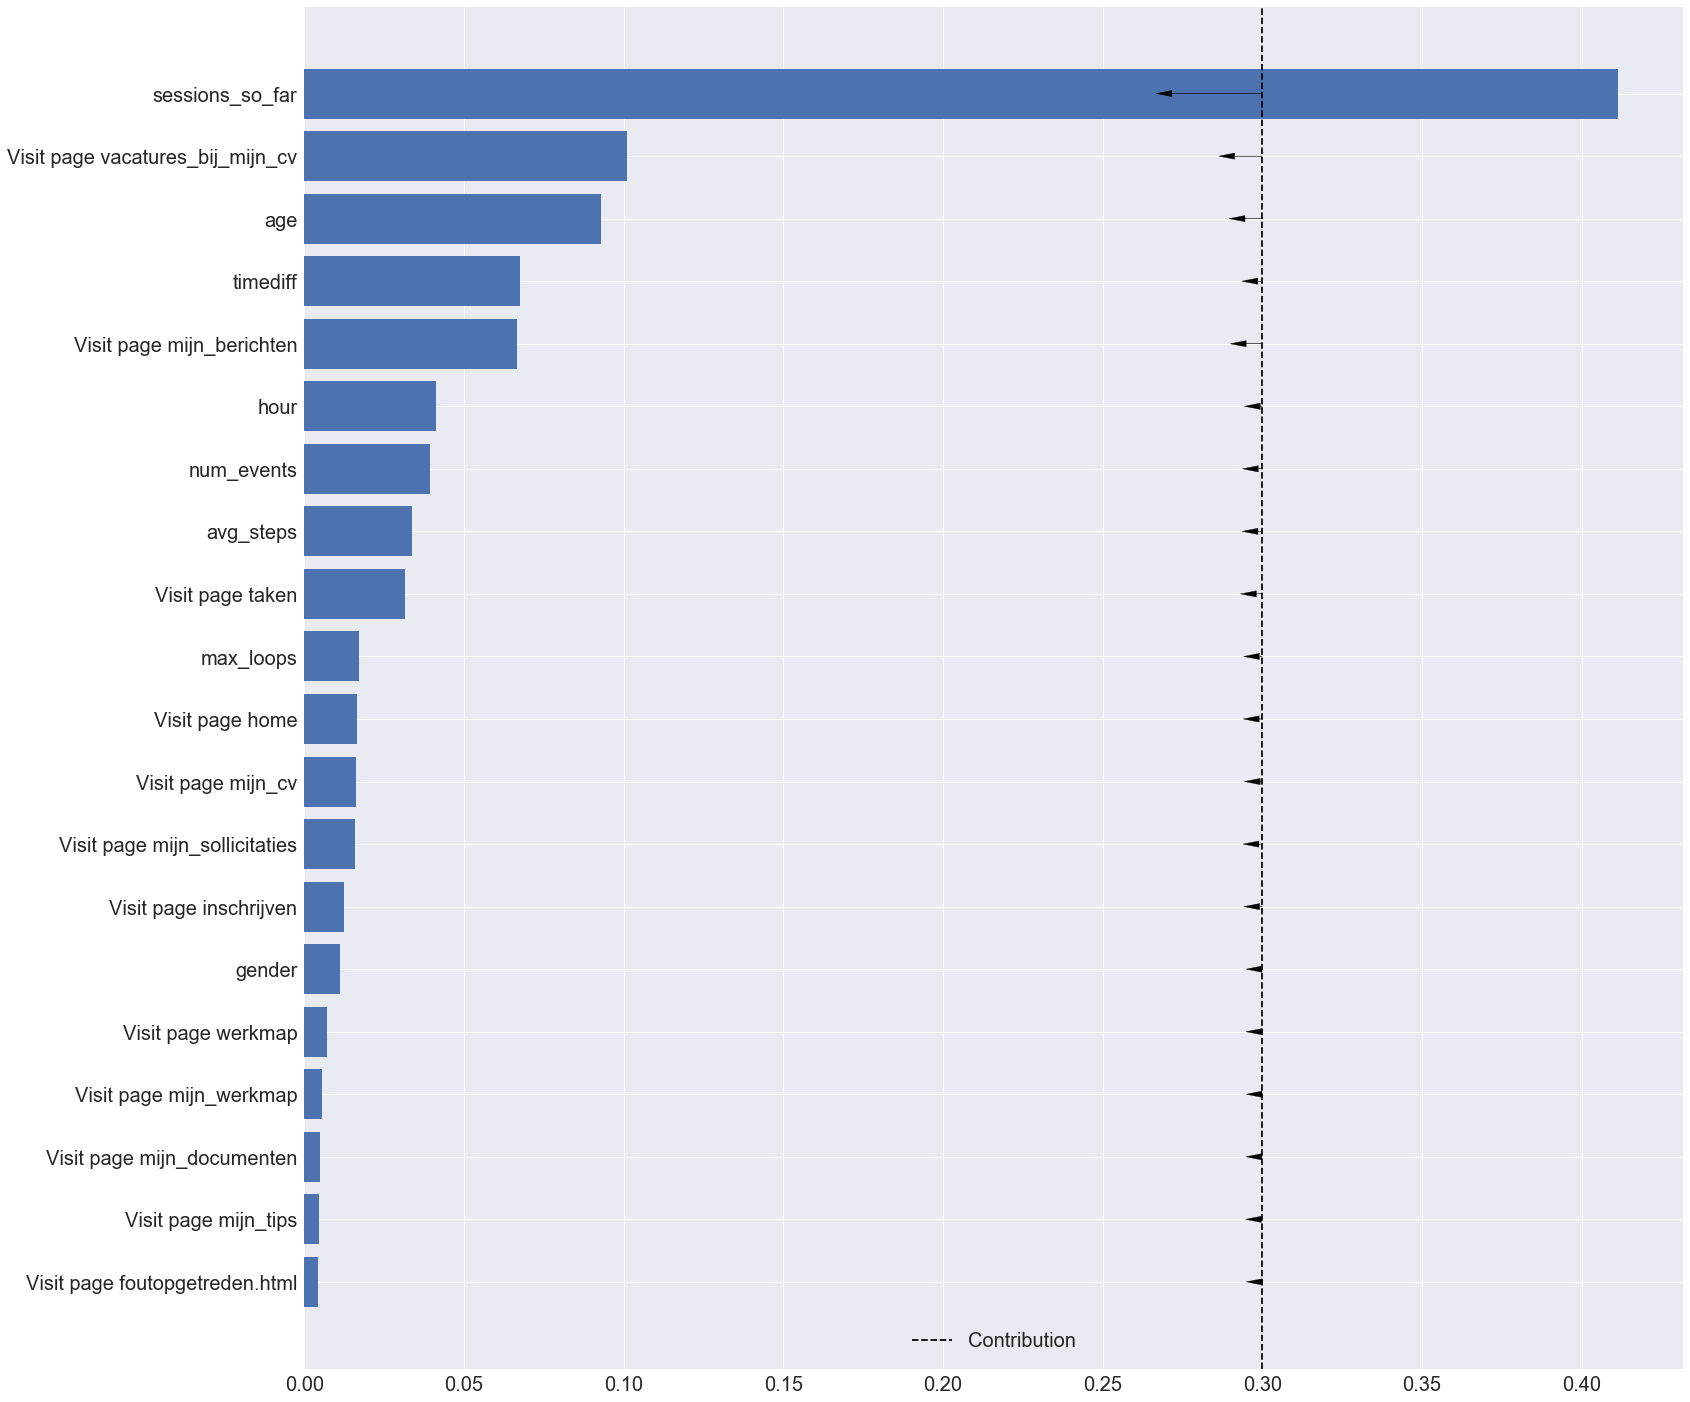

In [74]:
import matplotlib.pyplot as plt

def f_importances(coef, total_contribution, names):
    imp = coef
    imp, names, total_contribution = zip(*sorted(zip(imp,names,total_contribution)))
    sns.set(font_scale=2)
    plt.figure(figsize=(24, 20))
    plt.barh(range(len(names)), imp, align='center')
    pos_imp = 0.3
    for i in range(len(names)):
        plt.arrow(x = pos_imp, y = i, dx = total_contribution[i] * 4 , dy= 0,fc="k", ec="k", head_width=0.1, head_length=0.005)
        
    plt.axvline(x = pos_imp, linestyle='dashed', color='black', label = 'Contribution')
    plt.legend(loc='lower center')
    plt.yticks(range(len(names)), names)
    plt.tight_layout()
    plt.savefig('Important features')
    plt.show()

    
f_importances(model.feature_importances_, total_contribution, features)


# Predictions/Predictions_prob

In [ ]:
predictions_prob_compl = model.predict_proba(X)[:,1]

fpr, tpr, thresholds = roc_curve(y, predictions_prob_compl)
roc_auc = auc(fpr, tpr)
opt_threshold, opt_fpr, opt_trp = optimal_threshold(fpr, tpr, thresholds)

predictions_compl= predictions_prob_compl.copy()
predictions_compl[predictions_compl<opt_threshold] = 0
predictions_compl[predictions_compl>=opt_threshold] = 1

